### 參考文章：[Kaggle競賽-鐵達尼號生存預測(Top 3%)](https://medium.com/@yulongtsai/https-medium-com-yulongtsai-titanic-top3-8e64741cc11f)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, StratifiedKFold, learning_curve, train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import RFECV
import warnings
warnings.filterwarnings('ignore')

from IPython.display import display
from IPython.display import display_html
def display_side_by_side(*args):
    html_str=''
    for df in args:
        html_str+=df.to_html()
    display_html(html_str.replace('table', 'table style="display:inline"'), raw=True)

In [2]:
train_df = pd.read_csv('data/train.csv')
test_df = pd.read_csv('data/test.csv')
data_df = train_df.append(test_df)
data_df.head()

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket
0,22.0,NaN,S,7.2500,"Braund, Mr. Owen Harris",0,1,3,male,1,0.0,A/5 21171
1,38.0,C85,C,71.2833,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,2,1,female,1,1.0,PC 17599
2,26.0,NaN,S,7.9250,"Heikkinen, Miss. Laina",0,3,3,female,0,1.0,STON/O2. 3101282
3,35.0,C123,S,53.1000,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,4,1,female,1,1.0,113803
4,35.0,NaN,S,8.0500,"Allen, Mr. William Henry",0,5,3,male,0,0.0,373450


,Sex,Survived
0,female,0.742
1,male,0.189


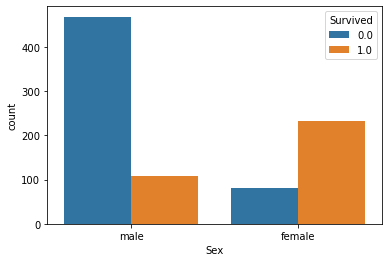

In [3]:
sns.countplot(data_df['Sex'], hue=data_df['Survived'])
data_df[['Sex', 'Survived']].groupby(['Sex'], as_index=False).mean().round(3)

,Pclass,Survived
0,1,0.630
1,2,0.473
2,3,0.242


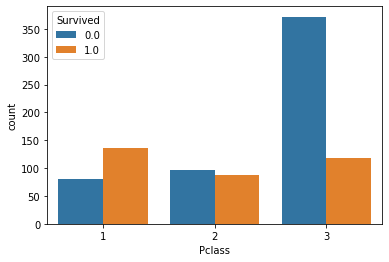

In [4]:
sns.countplot(data_df['Pclass'], hue=data_df['Survived'])
data_df[['Pclass', 'Survived']].groupby(['Pclass'], as_index=False).mean().round(3)

In [5]:
# 將性別資料轉為 0 1，0 為女性，1 為男性
data_df['Sex_Code'] = data_df['Sex'].map({'female':0, 'male':1}).astype('int')
data_df.head()

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket,Sex_Code
0,22.0,NaN,S,7.2500,"Braund, Mr. Owen Harris",0,1,3,male,1,0.0,A/5 21171,1
1,38.0,C85,C,71.2833,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,2,1,female,1,1.0,PC 17599,0
2,26.0,NaN,S,7.9250,"Heikkinen, Miss. Laina",0,3,3,female,0,1.0,STON/O2. 3101282,0
3,35.0,C123,S,53.1000,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,4,1,female,1,1.0,113803,0
4,35.0,NaN,S,8.0500,"Allen, Mr. William Henry",0,5,3,male,0,0.0,373450,1


In [6]:
# 分開訓練和測試集
train_df = data_df[:len(train_df)]
test_df = data_df[len(train_df):]

In [7]:
# 生還與否設定為目標 Y，其餘為訓練資料 X
X = train_df.drop(labels=['Survived', 'PassengerId'], axis=1)
Y = train_df['Survived']

In [8]:
# Show Bseline
Base = ['Sex_Code', 'Pclass']
Base_Model = RandomForestClassifier(random_state=2, n_estimators=250, min_samples_split=20, oob_score=True)
Base_Model.fit(X[Base], Y)
print('Base oob score: %.5f' %(Base_Model.oob_score_))

Base oob score: 0.73176


In [16]:
Predict = Base_Model.predict(test_df[Base])
Predict_result = pd.DataFrame({'PassengerId':test_df['PassengerId'], 'Survived':Predict}).astype(int)
Predict_result.head()

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1


In [17]:
Predict_result.to_csv('submission.csv', index=False)

## 加入票價

Fare        
Survived    0.0     1.0
Pclass                 
1         44.75  77.958
2         13.00  21.000
3          8.05   8.517

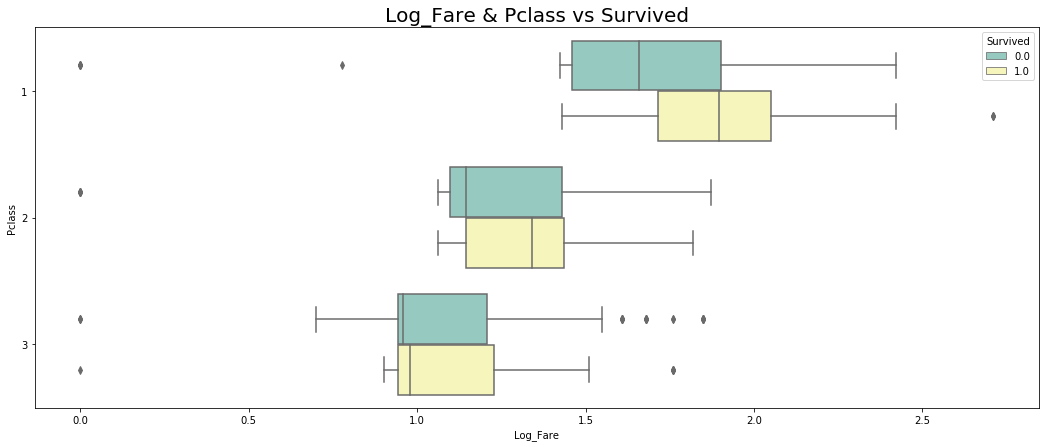

In [9]:
fig, ax = plt.subplots(figsize=(18, 7))
data_df['Log_Fare'] = (data_df['Fare']+1).map(lambda x:np.log10(x) if x > 0 else 0)
sns.boxplot(y='Pclass', x='Log_Fare', hue='Survived', data=data_df, orient='h',
           ax=ax, palette='Set3')
ax.set_title('Log_Fare & Pclass vs Survived', fontsize=20)
pd.pivot_table(data_df, values=['Fare'], index=['Pclass'], columns=['Survived'], aggfunc='median').round(3)

從表和圖中可以看出存活下來的乘客確實平均而言付出較高的票價，決定測試這個特徵
然而，測試之前需要將票價切分成幾個區間，才不會讓模型 overfit 太嚴重
如此問題就來了，切成幾塊比較合適呢?

首先填補缺失值，由於只有一項，填入中位數

In [10]:
# filling missing values
data_df['Fare'] = data_df['Fare'].fillna(data_df['Fare'].median())

用極限的觀點來考慮區間切分問題 :
   * 當切分的區間太少時，區間內的資料太多一起平均，這樣沒有辦法看出差異性，使得特徵失真
   * 當切分區間太多時，一點點票價的不同，都影響了生存率的高低，如此一來很明顯地會overfitting，並且，切分區間趨近於無限大時，就回到了原本的數值特徵

下列程式碼將票價分別切分成 4, 5, 6 的區間，並命名為新的特徵

Pclass,1,2,3
FareBin_Code_4,,,
0,8,6,323
1,0,128,193
2,77,104,147
3,238,39,46
Pclass,1,2,3
FareBin_Code_5,,,
0,8,6,261
1,0,36,218
2,0,124,132


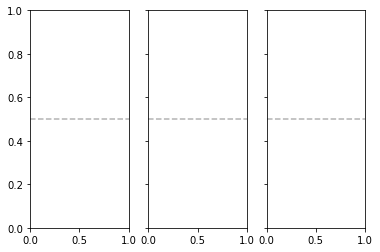

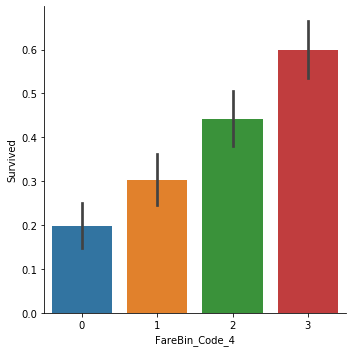

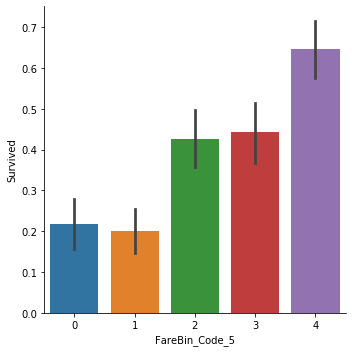

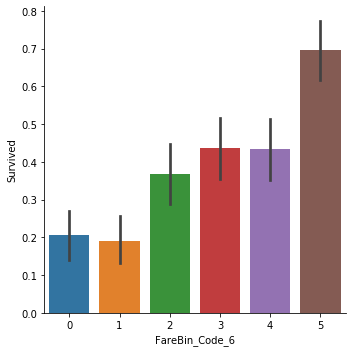

In [11]:
# Making Bins
data_df['FareBin_4'] = pd.qcut(data_df['Fare'], 4)
data_df['FareBin_5'] = pd.qcut(data_df['Fare'], 5)
data_df['FareBin_6'] = pd.qcut(data_df['Fare'], 6)

label = LabelEncoder()
data_df['FareBin_Code_4'] = label.fit_transform(data_df['FareBin_4'])
data_df['FareBin_Code_5'] = label.fit_transform(data_df['FareBin_5'])
data_df['FareBin_Code_6'] = label.fit_transform(data_df['FareBin_6'])

# cross tab
df_4 = pd.crosstab(data_df['FareBin_Code_4'],data_df['Pclass'])
df_5 = pd.crosstab(data_df['FareBin_Code_5'],data_df['Pclass'])
df_6 = pd.crosstab(data_df['FareBin_Code_6'],data_df['Pclass'])

display_side_by_side(df_4, df_5, df_6)

# plots
fig, [ax1, ax2, ax3] = plt.subplots(1, 3,sharey=True)
# fig.set_figwidth(18)
for axi in [ax1, ax2, ax3]:
    axi.axhline(0.5,linestyle='dashed', c='black', alpha = .3)
g1 = sns.factorplot(x='FareBin_Code_4', y="Survived", data=data_df,kind='bar', ax=ax1)
g2 = sns.factorplot(x='FareBin_Code_5', y="Survived", data=data_df,kind='bar', ax=ax2)
g3 = sns.factorplot(x='FareBin_Code_6', y="Survived", data=data_df,kind='bar', ax=ax3)
# close FacetGrid object
# plt.close(g1.fig)
# plt.close(g2.fig)
# plt.close(g3.fig)

Pandas 中提供了蠻多種切分數值特徵的方式，這裡選用 qcut，qcut 是以累積百分比來切分的

例如將副指令 = 4，就會以 0% ~ 25%, 25% ~ 50%, 50% ~ 75%, 75% ~ 100% 來切分資料

好處是我們可以避免某個區間內的資料過少(skew problem)

In [12]:
# splits again beacuse we just engineered new feature
train_df = data_df[:len(train_df)]
test_df = data_df[len(train_df):]

# Training set and labels
X = train_df.drop(labels=['Survived', 'PassengerId'],axis=1)
Y = train_df['Survived']

# show columns
X.columns

Index(['Age', 'Cabin', 'Embarked', 'Fare', 'Name', 'Parch', 'Pclass', 'Sex',
       'SibSp', 'Ticket', 'Sex_Code', 'Log_Fare', 'FareBin_4', 'FareBin_5',
       'FareBin_6', 'FareBin_Code_4', 'FareBin_Code_5', 'FareBin_Code_6'],
      dtype='object')

對於特徵選擇 (Feature Slection) 的問題

這裡利用前向選擇法 (RFE) 做特徵選擇

特徵選擇的方法我們有幾個選項，一是用單變數的 Chi square、或是 information gain

但 RFE 可以考慮到特徵之間的交互作用，缺點是需要較大的運算資源

這點由於我們的資料集比較少而可以獲得緩解，在 Sklearn 上的實作也蠻簡單的

In [13]:
compare = ['Sex_Code', 'Pclass', 'FareBin_Code_4', 'FareBin_Code_5', 'FareBin_Code_6']
selector = RFECV(RandomForestClassifier(n_estimators=250, min_samples_split=20), cv=10, n_jobs=-1)
selector.fit(X[compare], Y)
print(selector.support_)
print(selector.ranking_)
print(selector.grid_scores_*100)

[ True  True  True  True  True]
[1 1 1 1 1]
[78.67290886 77.44444444 78.9051186  79.46441948 80.25468165]


在 CV 上可看到切分成 6 份可以得到比較高的 CV 分數

但是還沒有考慮到模型的 random_state 以及 Cross-Validation 切分的方式

必須小心謹慎的確認切成 6 份是否真的是最好的

下面針對 CV 及模型的 random_state 進行實驗

In [14]:
score_b4, score_b5, score_b6 = [], [], []
seeds = 10
for i in range(seeds):
    diff_cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=i)
    selector = RFECV(RandomForestClassifier(random_state=i, n_estimators=250, min_samples_split=20), cv=diff_cv, n_jobs=-1)
    selector.fit(X[compare], Y)
    score_b4.append(selector.grid_scores_[2])
    score_b5.append(selector.grid_scores_[3])
    score_b6.append(selector.grid_scores_[4])

## 畫圖

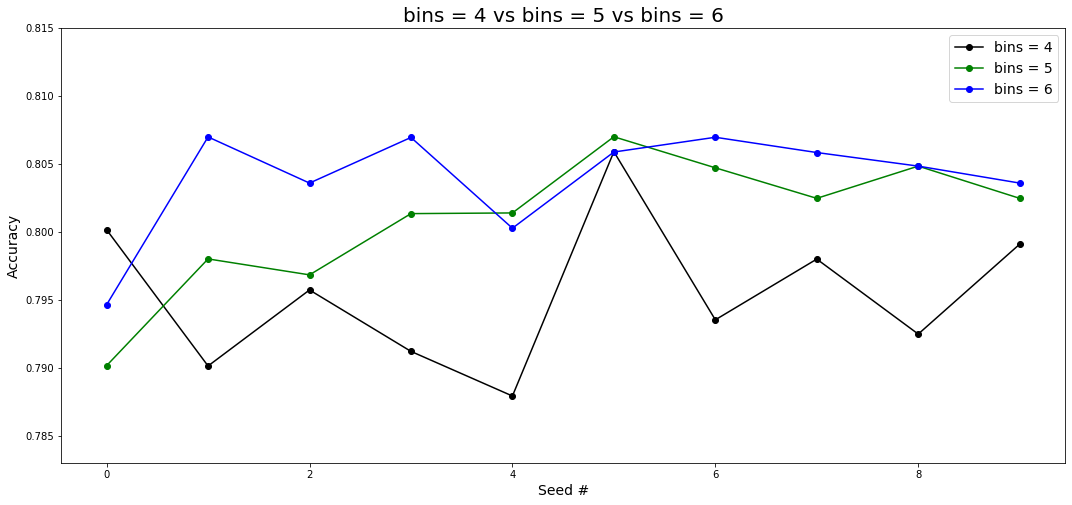

In [15]:
# to np.array
score_list = [score_b4, score_b5, score_b6]
for item in score_list:
    item = np.array(item*100)

# plot
fig = plt.figure(figsize= (18,8) )
ax = plt.gca()
ax.plot(range(seeds), score_b4,'-ok',label='bins = 4')
ax.plot(range(seeds), score_b5,'-og',label='bins = 5')
ax.plot(range(seeds), score_b6,'-ob',label='bins = 6')
ax.set_xlabel("Seed #", fontsize = '14')
ax.set_ylim(0.783,0.815)
ax.set_ylabel("Accuracy", fontsize = '14')
ax.set_title('bins = 4 vs bins = 5 vs bins = 6', fontsize='20')
plt.legend(fontsize = 14,loc='upper right')

上圖我們可以看出切分成 4 份的準確率較低

6 份比 5 份稍微好一點，在 CV 的結果是這樣

接下來分別將其提交到 Kaggle 上

這段程式碼和上面 Base Model 差不多，直接顯示 oob 分數以及提交的結果

In [16]:
b4, b5, b6 = ['Sex_Code', 'Pclass','FareBin_Code_4'], ['Sex_Code','Pclass','FareBin_Code_5'],\
['Sex_Code','Pclass','FareBin_Code_6']
b4_Model = RandomForestClassifier(random_state=2,n_estimators=250,min_samples_split=20,oob_score=True)
b4_Model.fit(X[b4], Y)
b5_Model = RandomForestClassifier(random_state=2,n_estimators=250,min_samples_split=20,oob_score=True)
b5_Model.fit(X[b5], Y)
b6_Model = RandomForestClassifier(random_state=2,n_estimators=250,min_samples_split=20,oob_score=True)
b6_Model.fit(X[b6], Y)
print('b4 oob score :%.5f' %(b4_Model.oob_score_),'   LB_Public : 0.7790')
print('b5 oob score :%.5f '%(b5_Model.oob_score_),' LB_Public : 0.79425')
print('b6 oob score : %.5f' %(b6_Model.oob_score_), '  LB_Public : 0.77033')

b4 oob score :0.80584    LB_Public : 0.7790
b5 oob score :0.81033   LB_Public : 0.79425
b6 oob score : 0.80135   LB_Public : 0.77033


在排行榜上的分數反而是切分成 5 份最高分，而不是6份

這個情況在 Titanic 這個資料集上很常見

可能是某種過度的特徵工程所帶來的 overfitting

特徵工程在數學上也可以想像成原始特徵的非線性轉換，僅僅是我們賦予了每一種特徵工程對應的意義

最終都必須得在 CV 以及排行榜上測試

將 b5_Model 提交至 Kaggle

In [22]:
# Submit
X_Submit = test_df.drop(labels=['PassengerId'], axis=1)

b5_pred = b5_Model.predict(X_Submit[b5])

submit = pd.DataFrame({'PassengerId': test_df['PassengerId'],
                      'Survived': b5_pred.astype(int)})
submit.to_csv('submit_b5.csv', index=False)

In [23]:
# Submit b6
X_Submit = test_df.drop(labels=['PassengerId'], axis=1)

b6_pred = b6_Model.predict(X_Submit[b6])

submit = pd.DataFrame({'PassengerId': test_df['PassengerId'],
                      'Survived': b6_pred.astype(int)})
submit.to_csv('submit_b6.csv', index=False)

## 連結(Connected_Survival)
這個特徵相當有意思，主要是發現了乘客持有相同的船票意味著他們可能是家人或是朋友

而在訓練集上這些互相有連結的人常常是一起活下來或是一起喪命，從票根的特徵 Ticket 開始看起

In [17]:
train_df['Ticket'].describe()

count      891
unique     681
top       1601
freq         7
Name: Ticket, dtype: object

891 個票根資訊中

獨立的有 681 項

表示一定有乘客是持有相同的票根，這意味著他們可能一起分享某一區的座位......

建立家庭人數特徵 (將兄弟姊妹數 SibSp + 父母小孩數 Parch + 1) 方便接下來的觀察

In [18]:
# Family_size
data_df['Family_size'] = data_df['SibSp'] + data_df['Parch'] + 1

建立持有相同票根的 DataFrame，顯示姓名、票價、艙位、家庭人數

In [19]:
deplicate_ticket = []
for tk in data_df.Ticket.unique():
    tem = data_df.loc[data_df.Ticket == tk, 'Fare']
    if tem.count() > 1:
        deplicate_ticket.append(data_df.loc[data_df.Ticket == tk, ['Name', 'Ticket', 'Fare', 'Cabin', 'Family_size', 'Survived']])
deplicate_ticket = pd.concat(deplicate_ticket)
deplicate_ticket.head(14)

,Name,Ticket,Fare,Cabin,Family_size,Survived
1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",PC 17599,71.2833,C85,2,1.0
234,"Cumings, Mr. John Bradley",PC 17599,71.2833,C85,2,NaN
3,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",113803,53.1000,C123,2,1.0
137,"Futrelle, Mr. Jacques Heath",113803,53.1000,C123,2,0.0
6,"McCarthy, Mr. Timothy J",17463,51.8625,E46,1,0.0
146,"Hilliard, Mr. Herbert Henry",17463,51.8625,E46,1,NaN
7,"Palsson, Master. Gosta Leonard",349909,21.0750,NaN,5,0.0
24,"Palsson, Miss. Torborg Danira",349909,21.0750,NaN,5,0.0
374,"Palsson, Miss. Stina Viola",349909,21.0750,NaN,5,0.0
567,"Palsson, Mrs. Nils (Alma Cornelia Berglund)",349909,21.0750,NaN,5,0.0


## 編號 7, 24, 374, 567, 389
* 該家族有可能是全部一起喪命的 (縱使有一個是測試集中的資料)
* 也可以從姓名中看出，5 名成員皆為 Palsson 家族
* 一位先生 (Mr.) 及兩位小姐 (Miss) 帶著兩位小男孩 (Master) 搭上了鐵達尼號，票根皆為349909，甚至票價也相同

## 編號 8, 172, 869
* 皆為 Johnson 家族的成員，兩位女性 (Mrs.及Miss) 帶著一位小男孩 (Master) 搭上了船
* 這則是一個三位乘客皆存活的例子
* 未必所有的群組都是同生同死 (如編號 3, 137)

## 其他案例
* 可以從編號 6, 146 的這個群組看出兩位一起搭船，但並非是親屬關係 (姓名中的姓氏不同)
* 可以推定可能是朋友或是基於甚麼原因共同搭船的人，可能在船難發生時互相幫忙

## 親屬關係認定
* 可以透過家庭成員人數這個特徵來分類
* Family_size = 1，但是又在群組內的，即非親屬關係，我們歸類為朋友; Family_size > 1 則為家人

In [21]:
friend_df = deplicate_ticket.loc[(deplicate_ticket.Family_size == 1) & (deplicate_ticket.Survived.notnull())].head(7)
family_df = deplicate_ticket.loc[(deplicate_ticket.Family_size > 1) & (deplicate_ticket.Survived.notnull())].head(7)
display(friend_df, family_df)
print('people keep the same ticket: %.0f '%len(deplicate_ticket))
print('friends: %.0f '%len(deplicate_ticket[deplicate_ticket.Family_size == 1]))
print('families: %.0f '%len(deplicate_ticket[deplicate_ticket.Family_size > 1]))

,Name,Ticket,Fare,Cabin,Family_size,Survived
6,"McCarthy, Mr. Timothy J",17463,51.8625,E46,1,0.0
20,"Fynney, Mr. Joseph J",239865,26.0000,NaN,1,0.0
791,"Gaskell, Mr. Alfred",239865,26.0000,NaN,1,0.0
195,"Lurette, Miss. Elise",PC 17569,146.5208,B80,1,1.0
681,"Hassab, Mr. Hammad",PC 17572,76.7292,D49,1,1.0
61,"Icard, Miss. Amelie",113572,80.0000,B28,1,1.0
829,"Stone, Mrs. George Nelson (Martha Evelyn)",113572,80.0000,B28,1,1.0


,Name,Ticket,Fare,Cabin,Family_size,Survived
1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",PC 17599,71.2833,C85,2,1.0
3,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",113803,53.1000,C123,2,1.0
137,"Futrelle, Mr. Jacques Heath",113803,53.1000,C123,2,0.0
7,"Palsson, Master. Gosta Leonard",349909,21.0750,NaN,5,0.0
24,"Palsson, Miss. Torborg Danira",349909,21.0750,NaN,5,0.0
374,"Palsson, Miss. Stina Viola",349909,21.0750,NaN,5,0.0
567,"Palsson, Mrs. Nils (Alma Cornelia Berglund)",349909,21.0750,NaN,5,0.0


people keep the same ticket: 596 
friends: 127 
families: 469 


有約莫600位乘客和他人持有相同票根

其中大概有75%為家庭出遊

接著依照以觀察來創建一個新的特徵

In [22]:
deplicate_ticket = []
for tk in data_df.Ticket.unique():
    tem = data_df.loc[data_df.Ticket == tk, 'Fare']
    if tem.count() > 1:
        deplicate_ticket.append(data_df.loc[data_df.Ticket == tk, ['Name', 'Ticket', 'Fare', 'Cabin', 'Family_size', 'Survived']])
deplicate_ticket = pd.concat(deplicate_ticket)
deplicate_ticket.head(14)

,Name,Ticket,Fare,Cabin,Family_size,Survived
1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",PC 17599,71.2833,C85,2,1.0
234,"Cumings, Mr. John Bradley",PC 17599,71.2833,C85,2,NaN
3,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",113803,53.1000,C123,2,1.0
137,"Futrelle, Mr. Jacques Heath",113803,53.1000,C123,2,0.0
6,"McCarthy, Mr. Timothy J",17463,51.8625,E46,1,0.0
146,"Hilliard, Mr. Herbert Henry",17463,51.8625,E46,1,NaN
7,"Palsson, Master. Gosta Leonard",349909,21.0750,NaN,5,0.0
24,"Palsson, Miss. Torborg Danira",349909,21.0750,NaN,5,0.0
374,"Palsson, Miss. Stina Viola",349909,21.0750,NaN,5,0.0
567,"Palsson, Mrs. Nils (Alma Cornelia Berglund)",349909,21.0750,NaN,5,0.0


希望上表中票根 `PC 17599` 中的乘客建立 Connected_Survival = 1

以及票根 `17463` `349909` 中的乘客建立Connected_Survival = 0

但還須要多考慮沒有生還資訊的乘客 (同個票根中 Survived 都是 NaN 在測試集中) 的乘客，將 Connected_Survival = 0.5

* 過濾出重複的票根 : `if( len(df_grp) > 1)`
* 如果群組中有人生還 則定義 Connected_Survival = 1 : `if(smax == 1.0):`
* 沒有人生還，則定義 Connected_Survival = 0 : `if( smin == 0.0):`
* 剩下的沒有生還資訊，定義 Connected_Survival = 0.5 : 程式碼第一行 `data_df['Connected_Survival'] = 0.5`

In [27]:
# the same ticket family or friends
data_df['Connected_Survival'] = 0.5 # default 
for _, grp_df in data_df.groupby('Ticket'):
    if (len(grp_df) > 1):
        for ind, row in grp_df.iterrows():
            smax = grp_df.drop(ind)['Survived'].max()
            smin = grp_df.drop(ind)['Survived'].min()
            passID = row['PassengerId']
            if (smax == 1.0):
                data_df.loc[data_df['PassengerId'] == passID, 'Connected_Survival'] = 1
            elif (smin==0.0):
                data_df.loc[data_df['PassengerId'] == passID, 'Connected_Survival'] = 0
#print
print('people keep the same ticket: %.0f '%len(deplicate_ticket))
print("people have connected information : %.0f" 
      %(data_df[data_df['Connected_Survival']!=0.5].shape[0]))
data_df.groupby('Connected_Survival')[['Survived']].mean().round(3)

people keep the same ticket: 596 
people have connected information : 496


,Survived
Connected_Survival,
0.0,0.225
0.5,0.298
1.0,0.728


得到 596 位彼此持有相同票根的乘客

其中496位含有連結關係 (0 or 1 )

將其分組分別計算生還率

也還能把資料分的蠻開的，其中連結 =1 的生存率更是從 0.298 飆升至 0.728

完成特徵工程，分離訓練集、測試集，並分離出生還與否 (Y) 以及訓練資料 (X)

In [28]:
train_df = data_df[:len(train_df)]
test_df = data_df[len(train_df):]

# Training set and labels
X = train_df.drop(labels=['Survived', 'PassengerId'], axis=1)
Y = train_df['Survived']

加入模型、訓練，觀察 oob score

In [29]:
connect = ['Sex_Code', 'Pclass', 'FareBin_Code_5', 'Connected_Survival']
connect_Model = RandomForestClassifier(random_state=2, n_estimators=250, min_samples_split=20,
                                      oob_score=True)
connect_Model.fit(X[connect], Y)
print('connect oob score:%.5f' %(connect_Model.oob_score_))

connect oob score:0.82379


In [30]:
#submit
X_Submit = test_df.drop(labels=['PassengerId'], axis=1)

connect_pred = connect_Model.predict(X_Submit[connect])

submit = pd.DataFrame({'PassengerId': test_df['PassengerId'],
                      'Survived': connect_pred.astype(int)})

submit.to_csv('submit_connect.csv', index=False)

## 年齡
在這個特徵中會面臨 20% 缺失值的問題

和前面的票價 (Fare) 僅僅只有一項缺失值相比，缺的不少

而這很有可能影響預測，分兩個部分來討論:

截止目前為止，使用性別及艙等可以達到 0.76555 的準確率

後來加入了 2 項特徵提升了 4%

因此如果缺失年齡特別都屬於某個性別，或是特別都屬於某個艙等，就很有可能影響預測，以下觀察缺失值分佈的情況

Sex,female,male,All
Has_Age,,,
0,78,185,263
1,388,658,1046
All,466,843,1309


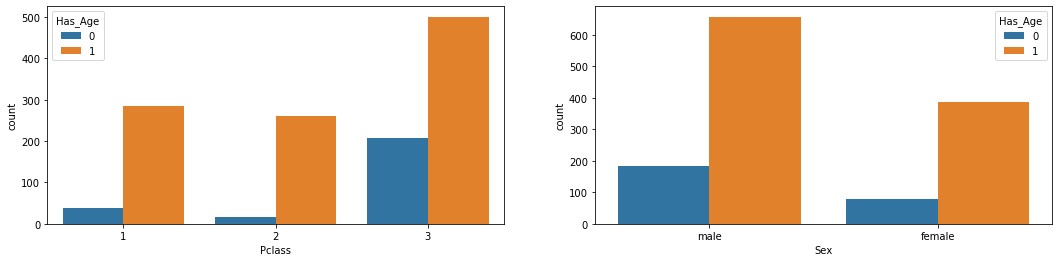

In [31]:
data_df['Has_Age'] = data_df['Age'].isnull().map(lambda x : 0 if x == True else 1)
fig, [ax1, ax2] = plt.subplots(1, 2)
fig.set_figwidth(18)
ax1 = sns.countplot(data_df['Pclass'],hue=data_df['Has_Age'],ax=ax1)
ax2 = sns.countplot(data_df['Sex'],hue=data_df['Has_Age'],ax=ax2)
pd.crosstab(data_df['Has_Age'],data_df['Sex'],margins=True).round(3)

### 左圖
* 左圖可以明顯的看出年齡缺失值蠻大部分在 3 等艙
* 如果年齡真的是個重要特徵，則我們對 3 等艙的觀察就會失真
* 保守的作法是觀察 1, 2 艙等中，年齡對存活與否的影響

### 右圖
* 顯示缺失值對性別的分布
* 搭配表格看的話，466 位女性有 78 位缺失年齡 (16.7%)
* 843 位男性有 185 位缺失年齡 (21.9%)，比例差了5%
* 男性缺失年齡稍微多一點，如果年齡對生存與否有影響的話，可能可以搭配男性藉此被區分出更多的生還者 (例如男性小孩生還率有可能高於男性成人)

1,2 艙之中，年齡對存活與否的影響:

Text(0.5, 1.0, 'Age vs Survived in Pclass=1 and 2')

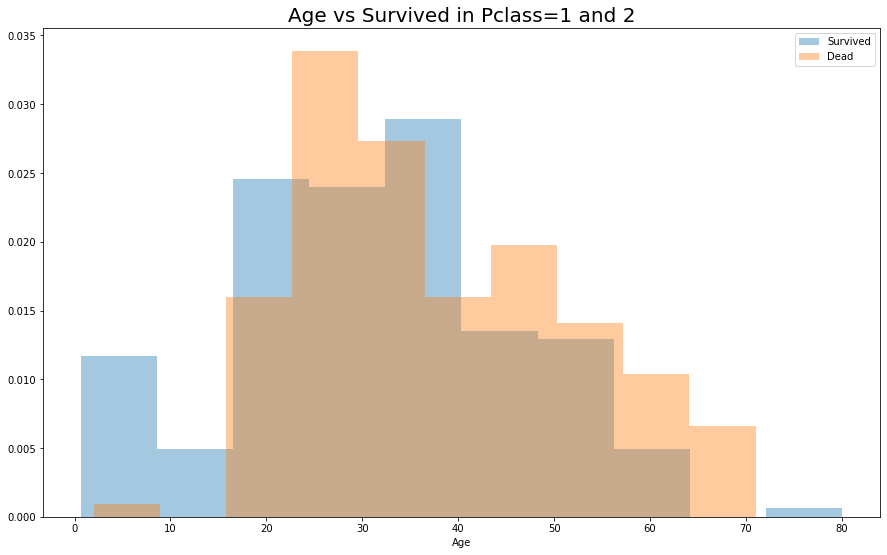

In [35]:
# Masks
Mask_Has_Age_P12_Survived = ((data_df.Has_Age == 1) & (data_df.Pclass != 3) & (data_df.Survived == 1))
Mask_Has_Age_P12_Dead = ((data_df.Has_Age == 1) & (data_df.Pclass != 3) & (data_df.Survived == 0))

# Plot
fig, ax = plt.subplots(figsize = (15, 9))
ax = sns.distplot(data_df.loc[Mask_Has_Age_P12_Survived, 'Age'], kde=False, bins=10, norm_hist=True, label='Survived')
ax = sns.distplot(data_df.loc[Mask_Has_Age_P12_Dead, 'Age'], kde=False, bins=10, norm_hist=True, label='Dead')
ax.legend()
ax.set_title('Age vs Survived in Pclass=1 and 2', fontsize=20)

圖中可以看到，左邊藍色的部分多出了一塊，也就是這部分生存率較高的，約 <16 歲

表示青少年以下 (包含小孩) 會有較高的生存率

同時，其餘部分也顯示出了，若 >16 歲，基本上年齡不算是一個顯著的特徵來判定是否生還

而 70~80 歲的這個區間，由於樣本數太少，因此不列入採計。

綜合上述 3 張圖的討論

找出那些 <16 歲的缺失值是重要的，這會影響預測

而 >16 歲的部分則不採用，否則只是擬合了噪聲

因此年齡這個特徵可以抽取出 <16 歲及 >16 歲做為一個 2 元特徵

填入缺失值的方式我們選擇使用姓名當中的稱謂中位數來填補，比起填中位數要準確的多

In [36]:
# extracted title using name
data_df['Title'] = data_df.Name.str.extract('([A-Za-z]+)\.', expand=False)
data_df['Title'] = data_df['Title'].replace(['Capt', 'Col', 'Countess', 'Don', 'Dr', 'Dona', 'Jonkheer', 'Major','Rev','Sir'],'Rare')
data_df['Title'] = data_df['Title'].replace(['Mlle', 'Ms','Mme'],'Miss')
data_df['Title'] = data_df['Title'].replace(['Lady'],'Mrs')
data_df['Title'] = data_df['Title'].map({"Mr":0, "Rare" : 1, "Master" : 2,"Miss" : 3, "Mrs" : 4 })
Ti = data_df.groupby('Title')['Age'].median()
Ti

Title
0    29.0
1    47.0
2     4.0
3    22.0
4    36.0
Name: Age, dtype: float64

列表為年齡中位數，先生 - 29 歲，罕見稱謂 - 47 歲，小男孩 - 4 歲，小姐- 22 歲， 女士 - 36 歲

不動原始特徵 Age，將填滿年齡的特徵創建為 Ti_Age，分為 <16 歲及 >16 歲，命名為 Ti_Minor

In [40]:
Ti_pred = data_df.groupby('Title')['Age'].median().values
data_df['Ti_Age'] = data_df['Age']

# Filling the missing age
for i in range(0, 5):
    data_df.loc[(data_df.Age.isnull()) & (data_df.Title == i), 'Ti_Age'] = Ti_pred[i]
    
data_df['Ti_Age'] = data_df['Ti_Age'].astype('int')
data_df['Ti_Minor'] = ((data_df['Ti_Age']) < 16.0) * 1

完成特徵工程，分離訓練集、測試集，分離出生還與否 (Y) 以及訓練資料 (X)

In [41]:
# split with new feature
train_df = data_df[:len(train_df)]
test_df = data_df[len(train_df):]

# Training set and labels
X = train_df.drop(labels=['Survived', 'PassengerId'], axis=1)
Y = train_df['Survived']

加入模型、訓練，觀察 oob score

In [42]:
minor = ['Sex_Code', 'Pclass', 'FareBin_Code_5', 'Connected_Survival', 'Ti_Minor']
minor_Model = RandomForestClassifier(random_state=2, n_estimators=250, min_samples_split=20, oob_score=True)
minor_Model.fit(X[minor], Y)
print('minor oob score: %.5f' %(minor_Model.oob_score_))

minor oob score: 0.84624


In [43]:
# submit
X_Submit = test_df.drop(labels=['PassengerId'], axis=1)

minor_pred = minor_Model.predict(X_Submit[minor])

submit = pd.DataFrame({'PassengerId': test_df['PassengerId'],
                      'Survived': minor_pred.astype(int)})

submit.to_csv('submit_minor.csv', index=False)